
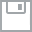
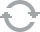
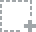
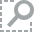
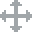
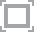
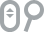
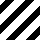
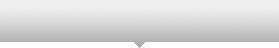
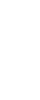
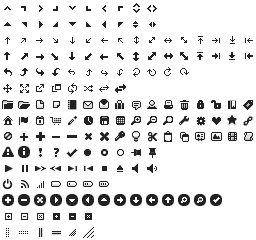
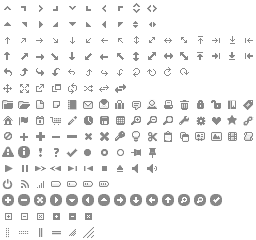
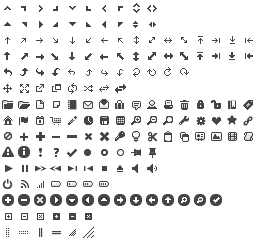
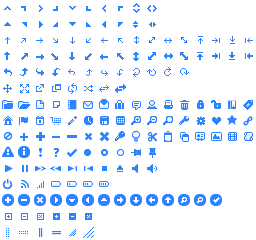
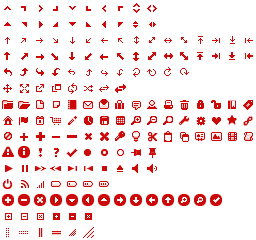
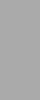
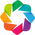
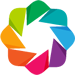

In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from bokeh.plotting import figure,show,output_notebook
from bokeh.models import Range1d

from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import cross_val_score, ShuffleSplit, train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing

from unbalanced_dataset import UnderSampler, OverSampler, SMOTE

output_notebook()
%matplotlib inline

In [2]:
pd.set_option('display.max_rows',100)
pd.set_option('display.max_columns',60)

In [3]:
df = None
anderson = list()
lynch = list()
nolan = list()
coen = list()
coppola = list()
jonze = list()
source = ['/Volumes/Ada/data/color_cube/extracted_colors_wes_anderson.csv',
          '/Volumes/Ada/data/color_cube/extracted_colors_david_lynch.csv',
          '/Volumes/Ada/data/color_cube/extracted_colors_christopher_nolan.csv',
          '/Volumes/Ada/data/color_cube/extracted_colors_coen_brothers.csv',
          '/Volumes/Ada/data/color_cube/extracted_colors_francis_ford_coppola.csv',
          '/Volumes/Ada/data/color_cube/extracted_colors_spike_jonze.csv',
         ]
def read_data(data=None, director=None):
    print(data)
    with open(data) as d_raw:
        reader = csv.reader(d_raw, delimiter=',', quotechar='"')
        counter = 0
        for row in reader:
            if len(row)> 15:
                continue
            director.append(row)
            counter += 1
            if counter == 11075:
                break
read_data(data=source[0], director=anderson)
read_data(data=source[1], director=lynch)
read_data(data=source[2], director=nolan)
read_data(data=source[3], director=coen)
read_data(data=source[4], director=coppola)
read_data(data=source[5], director=jonze)

/Volumes/Ada/data/color_cube/extracted_colors_wes_anderson.csv
/Volumes/Ada/data/color_cube/extracted_colors_david_lynch.csv
/Volumes/Ada/data/color_cube/extracted_colors_christopher_nolan.csv
/Volumes/Ada/data/color_cube/extracted_colors_coen_brothers.csv
/Volumes/Ada/data/color_cube/extracted_colors_francis_ford_coppola.csv
/Volumes/Ada/data/color_cube/extracted_colors_spike_jonze.csv


In [4]:
df = pd.DataFrame(data=nolan)
df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
count,11075,11075,11075,11075,11075,11075,11075,11075,11075,11075,11075,11075,11075,11075,11075
unique,254,1,253,9613,9613,9613,9613,9613,9592,9613,9613,9613,9613,2,251
top,154,christopher_nolan,154,#97689a659966,160.00529093506805,153.49981932875963,-0.009834914720032988,160.00529093506805,1.0,154.99964204667842,-109.13789761324111,11.951118231017688,6245.303791108189,batman_begins,155
freq,502,11075,525,19,19,19,19,19,22,19,19,19,19,8004,833


In [5]:
# load each csv into a data frame
df = df.append(anderson).append(lynch).append(coen).append(coppola).append(jonze)

# add column names for ease of exploration
df.columns = [
    'b',
    'director',
    'g',
    'hex',
    'hsl_hue',
    'hsl_lightness',
    'hsl_saturation',
    'hsv_hue',
    'hsv_saturation',
    'hsv_value',
    'lab_a_green_red',
    'lab_b_blue_yellow',
    'lab_l_lightness',
    'movie',
    'r',
]

In [6]:
df['director'].unique()

array(['christopher_nolan', 'wes_anderson', 'david_lynch', 'coen_brothers',
       'francis_ford_coppola', 'spike_jonze'], dtype=object)

In [7]:
df.describe()

,b,director,g,hex,hsl_hue,hsl_lightness,hsl_saturation,hsv_hue,hsv_saturation,hsv_value,lab_a_green_red,lab_b_blue_yellow,lab_l_lightness,movie,r
count,66450,66450,66450,66450,66450,66450,66450,66450,66450,66450,66450,66450,66450,66450,66450
unique,256,6,256,49021,49021,49021,49021,49021,48836,49021,49021,49021,49021,18,256
top,154,christopher_nolan,154,#15ea5aa5bc43,215.2095390157243,105.49971336481585,-0.7990483044040187,215.2095390157243,1.0,189.00003213967793,1716.9337494366382,-4830.917200444338,4270.918518304232,apocalypse_now,155
freq,2251,11075,2448,45,45,45,45,45,193,45,45,45,45,8729,5737


In [8]:
director_to_numeric = preprocessing.LabelEncoder()
df['target'] = director_to_numeric.fit_transform(df['director'])

In [9]:
df['target'].value_counts()

5    11075
4    11075
3    11075
2    11075
1    11075
0    11075
Name: target, dtype: int64

In [10]:
# convert all decimal and integer values to float data type
fields_to_convert = [
    'b',
    'g',
    'hsl_hue',
    'hsl_lightness',
    'hsl_saturation',
    'hsv_hue',
    'hsv_saturation',
    'hsv_value',
    'lab_a_green_red',
    'lab_b_blue_yellow',
    'lab_l_lightness',
    'r',
]
def convert_to_float(df=None):
    for field in fields_to_convert:
        df[field] = df[field].convert_objects(convert_numeric=True)

convert_to_float(df=df)

/Users/marswilliams/anaconda/envs/squirrel/lib/python2.7/site-packages/ipykernel/__main__.py:18: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


In [11]:
# initialize a logistic regression model
model_lr = LogisticRegression(C=1)

# define features, removing target variable, string fields, and fields where there is only one unique value
features = df.drop(['director', 'target','movie', 'hex'],axis=1)

# define target as director
target = df['target']

features.columns

Index([u'b', u'g', u'hsl_hue', u'hsl_lightness', u'hsl_saturation', u'hsv_hue',
       u'hsv_saturation', u'hsv_value', u'lab_a_green_red',
       u'lab_b_blue_yellow', u'lab_l_lightness', u'r'],
      dtype='object')

In [12]:
x = np.arange(len(features.columns))
names = features.columns
names

Index([u'b', u'g', u'hsl_hue', u'hsl_lightness', u'hsl_saturation', u'hsv_hue',
       u'hsv_saturation', u'hsv_value', u'lab_a_green_red',
       u'lab_b_blue_yellow', u'lab_l_lightness', u'r'],
      dtype='object')

In [13]:
# cross validate the model
cross_val_score(model_lr,features,target,cv=7).mean()


0.2466240623340834

In [14]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=1)
X_train

,b,g,hsl_hue,hsl_lightness,hsl_saturation,hsv_hue,hsv_saturation,hsv_value,lab_a_green_red,lab_b_blue_yellow,lab_l_lightness,r
6155,188,146,318.688356,176.499771,-0.173791,318.688356,0.294688,207.000009,2520.599206,-1066.324584,6586.769228,207
44,189,169,249.000997,178.999812,-0.056181,249.000997,0.105822,189.000031,427.472736,-841.270836,6787.816024,172
7679,22,153,44.914139,109.500011,-0.806452,44.914139,0.888325,197.000031,556.534843,5386.293888,6415.287991,197
10606,155,171,120.000107,162.999811,-0.049382,120.000107,0.093565,170.999626,-743.397882,542.535900,6643.420636,155
4153,39,99,29.032081,101.000018,-0.620000,29.032081,0.760736,163.000027,1853.058957,3679.229084,4926.601451,163
9474,205,233,165.882543,173.499746,-0.344927,165.882543,0.510729,232.999573,-3386.551043,305.934773,8087.909687,114
5430,115,118,1.373761,180.500030,-0.364902,1.373761,0.532520,246.000037,4157.625495,2208.525227,6373.524094,246
857,76,43,342.782363,100.499689,-0.577895,342.782363,0.727852,158.000025,4105.353566,856.526844,4039.367169,158
4612,141,89,319.480403,127.499802,-0.304350,319.480403,0.463858,166.000012,3284.481134,-1240.575265,4962.310106,166
8407,152,156,171.724779,141.499827,-0.103202,171.724779,0.185896,155.999671,-932.200307,-105.638200,6111.351399,127


In [15]:
# fit the model
model_lr = LogisticRegression(C=1).fit(X_train, y_train)

In [16]:
# get some cross validation scores for the fitted model
scores = cross_val_score(model_lr, features, target,cv=7).mean()
scores

0.24594686683085623

In [17]:
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=1)

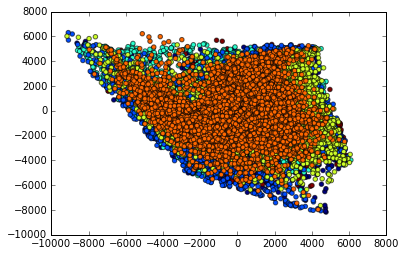

In [19]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=2)
pca.fit(features)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
X = pca.transform(features)
import pylab as pl
pl.scatter(X[:, 0], X[:, 1], c=target, alpha=100) 

In [20]:
from sklearn import svm
rbf_svc = svm.SVC(kernel='rbf', gamma=0.7, C=1.0).fit(X_train_pca, y_train)

In [21]:
# make some predictions
predictions = rbf_svc.predict(X_test_pca)
predictions

array([2, 0, 2, ..., 2, 3, 2])

In [22]:
# Create a confusion matrix to analyze predictions
cm = confusion_matrix(y_test,predictions)
cm

array([[ 241,  199, 1983,  173,  168,   82],
       [ 149,  348, 1826,  159,  113,   85],
       [  77,   84, 2287,  107,   95,   88],
       [  81,  110, 2000,  332,   99,   98],
       [ 156,  165, 1942,  153,  280,   91],
       [ 118,  185, 1991,  187,   96,  265]])

In [23]:
# Utility method to draw a confusion matrix
def plot_confusion_matrix(cm, target, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target.unique()))
    plt.xticks(tick_marks, target.unique(), rotation=45)
    plt.yticks(tick_marks, target.unique())
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    for y in [0,1]:
        for x in [0,1]:
            plt.text(x, y, '%.0f' % cm[y, x],
                     horizontalalignment='center',
                     verticalalignment='center',
                     color='grey',
                     fontsize=20)

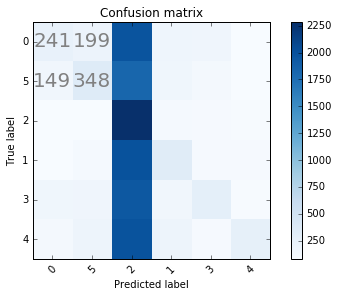

In [24]:
plot_confusion_matrix(cm, target)

In [26]:
scores = cross_val_score(rbf_svc, features, target,cv=7).mean()
scores

0.17480930844713066

Now that's not exactly the kind of results that I was hoping for...

In [ ]:
from sklearn import metrics

print metrics.classification_report([df['target'][label] for label in y_test], 
                                    [df['target'][label] for label in predictions])

In [3]:
from sklearn import svm
model_svm = svm.SVC(kernel='rbf')

ValueError: query data dimension must match training data dimension

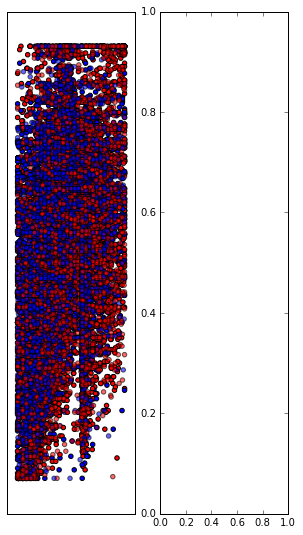

In [27]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=1)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

h = .02  # step size in the mesh

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Decision Tree",
         "Random Forest", "AdaBoost", "Naive Bayes", "Linear Discriminant Analysis",
         "Quadratic Discriminant Analysis"]
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]

datasets = [(features, target)]

figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds in datasets:
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
    # and testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, m_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot also the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
        # and testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1

figure.subplots_adjust(left=.02, right=.98)
plt.show()

In [ ]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=2)
pca.fit(features)
X = pca.transform(iris.data)
import pylab as pl
pl.scatter(X[:, 0], X[:, 1], c=target) 

In [156]:
from skimage import io, filters

image = data.coins() # or any NumPy array!
edges = filters.sobel(image)
io.imshow(edges)
io.show()

ValueError: X has 1 features per sample; expecting 24

In [ ]:
print model_lr.coef_
print model_lr.coef_.ravel()